# Fitting a Monod-Kinetic to fluorescently measured substrate concentration
In this example, we use toy data to demonstrate `murefi` features that help to fit a growth model to data that was obtained with non-trivial observation errors.

The fluorescent glucose biosensor, that was developed by Julia Otten at IBG-1 is a perfect example for such a scenario: At low glucose concentrations that occur at the end of batch cultivations, the sensor can be calibrated. At high concentrations, however, the sensor is saturated.

In [1]:
import numpy
import pandas
from matplotlib import pyplot
import scipy.optimize

import murefi

## Error Model

### Generating Fake Data
Because this is a toy example, we have to generate fake calibration data:

In [2]:
def logistic(y_hat, theta):
    I_x, I_y, Lmax, s = theta
    y_val = 2 * I_y - Lmax + (2 * (Lmax - I_y)) / (1 + numpy.exp(-4*s * (y_hat - I_x)))
    return y_val

theta_true = numpy.array([6.0, 0.75, 1.3, 0.2])

cal_concentrations = numpy.array([20, 18, 16, 14, 12, 10, 9, 8, 6, 5, 4, 3, 2, 1, 0.5, 0])
numpy.random.seed(2018)
cal_readouts = numpy.array([
    scipy.stats.t(loc=logistic(s, theta_true), scale=0.07, df=1).rvs(1)
    for s in cal_concentrations
])[:,0]

### Acquired Calibration Data
Let's assume that we have acquired calibration data with pairs of glucose concentration $S$ and FRET Ratios $R$ that look like this:

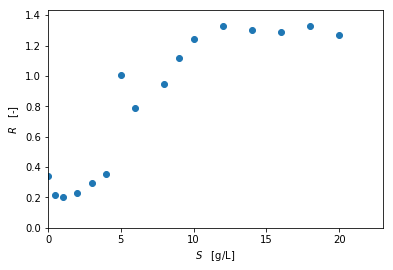

In [3]:
pyplot.scatter(cal_concentrations, cal_readouts)
pyplot.xlim(0, 23)
pyplot.ylim(0, cal_readouts.max() + 0.1)
pyplot.xlabel('$S$   [g/L]')
pyplot.ylabel('$R$   [-]')
pyplot.show()

### Implementing the Error Model
The calibration measurement are obviously subject to observation noise. Also, the sensor seems to be _in saturation_ at concentrations higher than about 10 g/L.

To account for these imprecisions in our Monod model, we first have to set up an _error model_ for the glucose observations.

In [4]:
class GlucoseErrorModel(murefi.ErrorModel):    
    def logistic(self, y_hat, theta):
        """Logistic model of the expected readout, given a true concentration.
        
        Arguments:
            y_hat (array): realizations of the independent variable (concentrations)
            theta_log (array): parameters of the logistic model
                I_x: inflection point (x)
                I_y: inflection point (y)
                Lmax: maximum value
                s: slope at the inflection point
        """
        I_x, I_y, Lmax, s = theta
        y_val = 2 * I_y - Lmax + (2 * (Lmax - I_y)) / (1 + numpy.exp(-4*s * (y_hat - I_x)))
        return y_val
    
    def error_model(self, y_hat, theta):
        mu = self.logistic(y_hat, theta[:4])
        # for simplicitly of this example, we model the noise to be independent from y_hat
        # in many real-world scenarios, the noise may actually depend on y_hat as well
        sigma = numpy.repeat(theta[4], len(y_hat))
        # the t-distribution is also parameterized by a 'shape'. In this example it is always =1
        df = 1
        return mu, sigma, df
        
    def loglikelihood(self, y, y_hat, theta):
        mu, sigma, df = self.error_model(y_hat, theta)
        # assuming t-distributed observation noise
        likelihoods = scipy.stats.t.pdf(x=y, loc=mu, scale=sigma, df=1)
        loglikelihoods = numpy.log(likelihoods)
        ll = numpy.sum(loglikelihoods)
        return ll
    
    def fit(self, y, y_hat, theta_guessed, bounds):
        def sum_negative_loglikelihood(theta):
            return(-self.loglikelihood(y, y_hat, theta))
        fit = scipy.optimize.minimize(sum_negative_loglikelihood, theta_guessed, bounds=bounds)
        self.theta_fitted = fit.x
        return fit

### Fitting the error model
Thanks to the `fit` function, all we need to do is set up some parameter bounds and initial guesses.

In [5]:
name_guess_low_up = [
    # name      guess   lower_bound    upper_bound
    ('I_x',     7,      4,             15),
    ('I_y',     0.7,    0.3,           1.4),
    ('L_max',   1.3,    1.0,           1.5),
    ('slope',   0.1,    0.01,          3),
    ('sigma',   0.2,    0.01,          0.5),
]

df_fit = pandas.DataFrame(columns=['name', 'guess', 'bounds', 'fit', 'hit_bounds'])
df_fit['name'] = [p for p, g, l, u in name_guess_low_up]
df_fit['guess'] = [g for p, g, l, u in name_guess_low_up]
df_fit['bounds'] = [(l,u) for p, g, l, u in name_guess_low_up]
df_fit['fit'] = None
df_fit['hit_bounds'] = None

gem = GlucoseErrorModel(independent='S', dependent='R')
fit = gem.fit(cal_readouts, cal_concentrations, df_fit['guess'], bounds=df_fit['bounds'])

if not fit.success:
    print(fit)

df_fit['fit'] = fit.x
lower_bounds = [l for l, u in df_fit['bounds']]
upper_bounds = [u for l, u in df_fit['bounds']]
df_fit['hit_bounds'] = numpy.logical_or(
    numpy.isclose(fit.x, lower_bounds, rtol=0.01),
    numpy.isclose(fit.x, upper_bounds, rtol=0.01)
)
df_fit

,name,guess,bounds,fit,hit_bounds
0,I_x,7.0,"(4, 15)",6.711241,False
1,I_y,0.7,"(0.3, 1.4)",0.755066,False
2,L_max,1.3,"(1.0, 1.5)",1.314575,False
3,slope,0.1,"(0.01, 3)",0.167446,False
4,sigma,0.2,"(0.01, 0.5)",0.020664,False


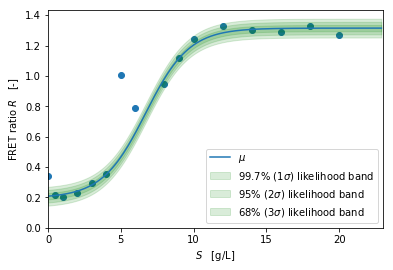

In [6]:
x_dense = numpy.arange(0, 23, 0.1)

mu, sigma, df = gem.error_model(y_hat=x_dense, theta=fit.x)

pyplot.plot(x_dense, mu, label='$\mu$')
pyplot.scatter(cal_concentrations, cal_readouts)
for s, percent in enumerate([99.7, 95, 68]):
    s = s + 1
    pyplot.fill_between(x_dense,
        mu-s*sigma,
        mu+s*sigma,
        alpha=.15, color='green', label=f'{percent}% (${s}\sigma$) likelihood band')

pyplot.xlim(0, 23)
pyplot.ylim(0, cal_readouts.max() + 0.1)
pyplot.xlabel('$S$   [g/L]')
pyplot.ylabel('FRET ratio $R$   [-]')
pyplot.legend()
pyplot.show()

## Setting up a Process Model
Now we can proceed with modeling our bioprocess.

### Implementing the Monod Kinetic
Here we will first implement the Monod kinetic.

In [9]:
class MonodModel(murefi.BaseODEModel):
    """ Class specifying the model for parameter fitting as Monod kinetics. """
    def dydt(self, y, t, theta):
        """First derivative of the transient variables.
        Args:
            y (array): array of observables
            t (float): time since intial state
            theta (array): Monod parameters
        Returns:
            array: change in y at time t
        """
        # NOTE: this method has significant performance impact!
        S, X = y
        S_0, X_0, mu_max, K_S, Y_XS = theta
        dXdt = mu_max * S * X / (K_S + S)
    
        yprime = [
            -1/Y_XS * dXdt,
            dXdt,
        ]
        return yprime
    
monod = MonodModel(keys_y=('S', 'X'))

### Generating Fake Process Measurements
Again, we have to generate fake data. This time we can use the implemented Monod model to generate fake data:

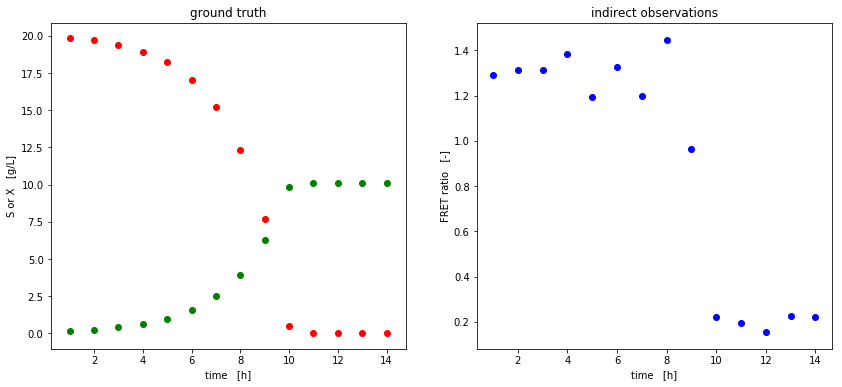

In [10]:
x_obs = numpy.arange(1, 15, 1)
x_dense = numpy.arange(1, 15, 0.1)

theta_monod_true = [20, 0.1, 0.46, 0.02, 0.5]

Y_true = monod.solver(
    y0=theta_monod_true[:2],
    x=x_obs,
    theta=theta_monod_true)
glucose_true = Y_true['S']
biomass_true = Y_true['X']

# here we generate fake measurements of the glucose sensor:
R_observed = []
for glc in glucose_true:
    mu, sigma, df = gem.error_model([glc], gem.theta_fitted)
    readout = scipy.stats.t(loc=mu, scale=sigma, df=df).rvs(1)[0]
    R_observed.append(readout)
R_observed = numpy.array(R_observed)

observed = murefi.Replicate('A1')
observed['R'] = murefi.Timeseries('R', x=x_obs, y=R_observed)

# now plot all of this
fig, (left, right) = pyplot.subplots(nrows=1, ncols=2, figsize=(14,6))

left.scatter(x_obs, glucose_true, label='S', color='red')
left.scatter(x_obs, biomass_true, label='X', color='green')
left.set_xlabel('time   [h]')
left.set_ylabel('S or X   [g/L]')
left.set_title('ground truth')

right.scatter(x_obs, R_observed, label='R', color='blue')
right.set_xlabel('time   [h]')
right.set_ylabel('FRET ratio   [-]')
right.set_title('indirect observations')
pyplot.show()

### Inspecting observed data
Now forget the plots above and assume that we have only the following observations.

Can we fit a Monod kinetic to this data?

Available data:
	Replicate([('R', <murefi.datatypes.Timeseries object at 0x000001ED8D38B198>)])


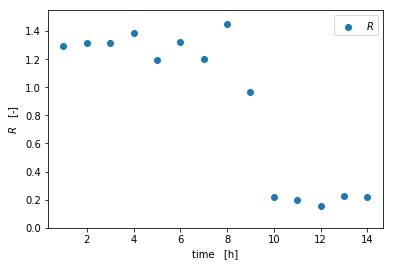

In [11]:
print(f'Available data:\n\t{observed}')

pyplot.scatter(observed['R'].x, observed['R'].y, label='$R$')
pyplot.xlabel('time   [h]')
pyplot.ylabel('$R$   [-]')
pyplot.ylim(0, observed['R'].y.max() + 0.1)
pyplot.legend()
pyplot.show()

### Fitting with a sophisticated Error Model
Finally, let's fit the process model using the previously determined error model.

In [12]:
def create_objective(model:murefi.BaseODEModel, error_models:murefi.ErrorModel,
                     data:murefi.Replicate):
    """Creates an objective function that can be minimized.
    
    Args:
        model (murefi.MonodModel): ODE model that makes predictions
        error_models (dictionary of murefi.ErrorModel): error models that shall be used to compute likelihoods
        data (murefi.Replicate): Replicate object for which the parameters should be fitted.
        par_map (murefi.ParameterMapping): Parameter map obtained with the corresponding murefi class
    """
    # add mock Timeseries to the data, because otherwise the prediction will not return
    # entries for those observable that were only observed indirectly
    for error_model in error_models:
        key_pred = error_model.independent
        key_obs = error_model.dependent
        if not key_pred in data:
            data[key_pred] = murefi.Timeseries(key_pred,
                x=data[key_obs].x, 
                y=numpy.repeat(numpy.nan, len(data[key_obs])))
    
    def negative_loglikelihood(theta_fit):
        L = 0
        
        prediction = monod.predict_replicate(parameters=theta_fit, template=data)
        
        # iterate over all error models - without error models we have no way to calculate L
        # each error model describes the likelihood of a dependent (key_obs)
        # variable as a function of the independent (key_pred) variable
        for error_model in error_models:
            key_pred = error_model.independent
            key_obs = error_model.dependent
            
            if key_obs in data and key_pred in prediction:
                t_pred = prediction[key_pred]
                t_obs = data[key_obs]
        
                ll = error_model.evaluate_loglikelihood(y=t_obs.y, y_hat=t_pred.y)
                L += numpy.sum(ll)
                
        if L == 0:
            raise Exception(f'keys_pred={prediction.keys()}, keys_obs={data.keys()}')
        if numpy.isnan(L):
            return -numpy.inf
        return -L
    return negative_loglikelihood

In [13]:
obj = create_objective(
    model=monod,
    error_models=[gem],
    data=observed
)

Finally, we have a fitting objective.

The toy problem involved only _indirect_ observations of the substrate, therefore fitting all 5 parameters at the same time will not work. Instead, we're fixing initial substrate and biomass concentrations, as well as the biomass yield.

This leaves $\mu_{max}$ and $K_S$ as the only two free parameters. They alone, will allow the glucose curve to describe pretty much any trajectory.

In [14]:
name_guess_low_up = [
    # name      guess   lower_bound    upper_bound
    ('S_0',     20,     20,            20),
    ('X_0',     0.1,    0.1,           0.1),
    ('mu_max',  0.40,   0.3,           0.7),
    ('K_S',     0.01,   0.001,         10),
    ('Y_XS',    0.5,    0.5,           0.5),
]

df_fit2 = pandas.DataFrame(columns=['name', 'guess', 'bounds', 'fit', 'hit_bounds'])
df_fit2['name'] = [p for p, g, l, u in name_guess_low_up]
df_fit2['guess'] = [g for p, g, l, u in name_guess_low_up]
df_fit2['bounds'] = [(l,u) for p, g, l, u in name_guess_low_up]
df_fit2['fit'] = None
df_fit2['hit_bounds'] = None

fit2 = scipy.optimize.minimize(obj, x0=df_fit2['guess'], bounds=df_fit2['bounds'])

if not fit2.success:
    print(fit2)

df_fit2['fit'] = fit2.x
lower_bounds = [l for l, u in df_fit2['bounds']]
upper_bounds = [u for l, u in df_fit2['bounds']]
df_fit2['hit_bounds'] = numpy.logical_or(
    numpy.isclose(fit2.x, lower_bounds, rtol=0.01),
    numpy.isclose(fit2.x, upper_bounds, rtol=0.01)
)
df_fit2

,name,guess,bounds,fit,hit_bounds
0,S_0,20.00,"(20, 20)",20.000000,True
1,X_0,0.10,"(0.1, 0.1)",0.100000,True
2,mu_max,0.40,"(0.3, 0.7)",0.462495,False
3,K_S,0.01,"(0.001, 10)",0.172328,False
4,Y_XS,0.50,"(0.5, 0.5)",0.500000,True


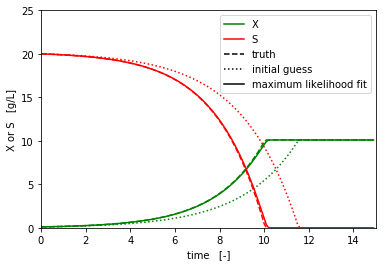

In [15]:
x_dense = numpy.arange(0, 15, 0.1)

Y_true = monod.solver(y0=theta_monod_true[:2], x=x_dense, theta=theta_monod_true)
Y_guess = monod.solver(y0=fit2.x[:2], x=x_dense, theta=df_fit2['guess'])
Y_pred = monod.solver(y0=fit2.x[:2], x=x_dense, theta=fit2.x)

fig, ax = pyplot.subplots()

ax.plot(x_dense, Y_true['X'], color='green', linestyle='--')
ax.plot(x_dense, Y_true['S'], color='red', linestyle='--')

ax.plot(x_dense, Y_guess['X'], color='green', linestyle=':')
ax.plot(x_dense, Y_guess['S'], color='red', linestyle=':')

ax.plot(x_dense, Y_pred['X'], color='green', label='X')
ax.plot(x_dense, Y_pred['S'], color='red', label='S')


ax.set_xlabel('time   [-]')
ax.set_ylabel('X or S   [g/L]')

ax.plot([20, 21], [0, 0], color='black', linestyle='--', label='truth')
ax.plot([20, 21], [0, 0], color='black', linestyle=':', label='initial guess')
ax.plot([20, 21], [0, 0], color='black', linestyle='-', label='maximum likelihood fit')

ax.set_xlim(0, 15)
ax.set_ylim(0, 25)

pyplot.legend()
pyplot.show()

### Conclusion
_Note:_ For demonstration purposes, this toy example was created with very few observed data points. Consequently, we have allowed unrealistic bounds $\mu_{max}$ and $K_S$ because the random fluctuations from small data points have a large effect on the fit.

The plot above shows that our model was successfully fitted agains the simulated FRET-ratio data by using the error model.

With a real dataset, there would be substantially more observations of FRET-ration, as shown by Julia in her last PhD seminar. Furthermore there would be biomass observations as well.